# Topic Modelling (Text Analytics)

As we all know that probabilistic topic models are a class of unsupervised machine learning models which help find the thematic patterns
present in data. They have been widely applied to a range of domains from text to images.
The basic topic model is called Latent Dirichlet Allocation (LDA) is being depicted by a
graphical model in plate notation.

These models are primarily generative models that describe how data, e.g., words in a
document are generated. We have also studied that a common “research” shortcoming
in probabilistic topic models is finding an appropriate number of topics. Given a dataset,
it is always difficult to find how many topics are ideal to describe that dataset. This
model is all about this bit!

To determine the ideal number of latent topics, what has been usually done in the
literature are the following (crucial hints!)
- Varying the number of topics arbitrarily and shown with respect to some measure
that one result or value obtained through that metric/measure is relatively better
than other values;
- Using a tuning strategy where the training data is split into training and tune
data. The topic model is tuned on the training data and evaluated on the tuned
data. The best evaluation result is then chosen as the ideal number of topics and
then this is applied on the test data;
- Using a Bayesian non-parametric approach to find the number of topics automatically.

In this work, we will cover two goals:
1. Which papers or research works have studied the problem of determining the number of topics 
- Similar to the approach used please visit https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
2. How can we determine the number of topics that are ideal for the dataset.

### Import all required packages from sci-kit learn library.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
import nltk
import string
import re
import gensim
from gensim.utils import simple_preprocess
import spacy
import en_core_web_sm
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import LdaModel
import numpy as np
import tqdm

### Load the dataset
Link to download the dataset from Kaggle https://www.kaggle.com/danofer/starter-dbpedia-extraction

In [2]:
dbpedia_df = pd.read_csv('DBP_wiki_data.csv')

### Explore the dataset
Check out the number of rows and columns

In [3]:
dbpedia_df.shape

(342781, 6)

### Randomly select only 10000 rows from the entire document. 
Depending on your machine's processor speed, you are free to explore all 342781 rows.

In [4]:
NUM_SAMPLES = 10000

### Format the dataset such that it can only hold 10000 rows.

In [5]:
dbpedia_df = dbpedia_df.sample(NUM_SAMPLES, replace=False).reset_index(drop=True)

In [6]:
dbpedia_df.head(5)

,text,l1,l2,l3,wiki_name,word_count
0,"Frühstück is a Polish Christian rock band, and...",Agent,Group,Band,Frühstück,43
1,Phyllis Pamela Green (28 March 1929 – 7 May 20...,Agent,Actor,AdultActor,Pamela_Green,48
2,The New York City mayoral election of 1993 occ...,Event,SocietalEvent,Election,"New_York_City_mayoral_election,_1993",63
3,"Roland Göhler (born March 26, 1943) is a Germa...",Agent,Athlete,Rower,Roland_Göhler,47
4,Asbestos Records is an American independent re...,Agent,Company,RecordLabel,Asbestos_Records,265


### Data Cleaning
Clean the data by dropping unnecessary column. The only column that will be focused on is the 'text' column.

In [8]:
dbpedia_df = dbpedia_df.drop(columns=['l2', 'l3', 'wiki_name', 
                              'word_count'], axis=1)

### Preprocessing (Punctuation mark)
Remove all punctuation marks from the documents

In [10]:
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

dbpedia_df['body_text_clean'] = dbpedia_df['text'].apply(lambda x: remove_punct(x))

dbpedia_df.head()

,text,l1,body_text_clean
0,"Frühstück is a Polish Christian rock band, and...",Agent,Frühstück is a Polish Christian rock band and ...
1,Phyllis Pamela Green (28 March 1929 – 7 May 20...,Agent,Phyllis Pamela Green 28 March 1929 – 7 May 201...
2,The New York City mayoral election of 1993 occ...,Event,The New York City mayoral election of 1993 occ...
3,"Roland Göhler (born March 26, 1943) is a Germa...",Agent,Roland Göhler born March 26 1943 is a German r...
4,Asbestos Records is an American independent re...,Agent,Asbestos Records is an American independent re...


### Preprocessing (Stop Words)
Remove all stop words, example of stop words are He, is, and, but, the, we etc 

In [11]:
#Stopword we are dealing is 'English' only
stopword = nltk.corpus.stopwords.words('english')

In [12]:
def remove_stopwords(tokenized_list):
    text_l = [word for word in tokenized_list if word not in stopword]
    return text_l

dbpedia_df['body_text_nostop'] = dbpedia_df['body_text_clean'].apply(lambda x: remove_stopwords(x))

dbpedia_df.head()

,text,l1,body_text_clean,body_text_nostop
0,"Frühstück is a Polish Christian rock band, and...",Agent,Frühstück is a Polish Christian rock band and ...,"[F, r, ü, h, ü, c, k, , , , P, l, h, , C, ..."
1,Phyllis Pamela Green (28 March 1929 – 7 May 20...,Agent,Phyllis Pamela Green 28 March 1929 – 7 May 201...,"[P, h, l, l, , P, e, l, , G, r, e, e, n, , ..."
2,The New York City mayoral election of 1993 occ...,Event,The New York City mayoral election of 1993 occ...,"[T, h, e, , N, e, w, , Y, r, k, , C, , r, ..."
3,"Roland Göhler (born March 26, 1943) is a Germa...",Agent,Roland Göhler born March 26 1943 is a German r...,"[R, l, n, , G, ö, h, l, e, r, , b, r, n, , ..."
4,Asbestos Records is an American independent re...,Agent,Asbestos Records is an American independent re...,"[A, b, e, , R, e, c, r, , , n, , A, e, r, ..."


### Preprocessing (Tokenize each words in the corpus)

In [13]:
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

dbpedia_df['body_text_tokenized'] = dbpedia_df['text'].apply(lambda x: tokenize(x.lower()))

dbpedia_df.head()

,text,l1,body_text_clean,body_text_nostop,body_text_tokenized
0,"Frühstück is a Polish Christian rock band, and...",Agent,Frühstück is a Polish Christian rock band and ...,"[F, r, ü, h, ü, c, k, , , , P, l, h, , C, ...","[frühstück, is, a, polish, christian, rock, ba..."
1,Phyllis Pamela Green (28 March 1929 – 7 May 20...,Agent,Phyllis Pamela Green 28 March 1929 – 7 May 201...,"[P, h, l, l, , P, e, l, , G, r, e, e, n, , ...","[phyllis, pamela, green, 28, march, 1929, 7, m..."
2,The New York City mayoral election of 1993 occ...,Event,The New York City mayoral election of 1993 occ...,"[T, h, e, , N, e, w, , Y, r, k, , C, , r, ...","[the, new, york, city, mayoral, election, of, ..."
3,"Roland Göhler (born March 26, 1943) is a Germa...",Agent,Roland Göhler born March 26 1943 is a German r...,"[R, l, n, , G, ö, h, l, e, r, , b, r, n, , ...","[roland, göhler, born, march, 26, 1943, is, a,..."
4,Asbestos Records is an American independent re...,Agent,Asbestos Records is an American independent re...,"[A, b, e, , R, e, c, r, , , n, , A, e, r, ...","[asbestos, records, is, an, american, independ..."


### Preprocessing (Lemmatize each word in the corpus)

In [14]:
wn = nltk.WordNetLemmatizer()
def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

dbpedia_df['body_text_lemmatized'] = dbpedia_df['text'].apply(lambda x: lemmatizing(x))

dbpedia_df.head()

,text,l1,body_text_clean,body_text_nostop,body_text_tokenized,body_text_lemmatized
0,"Frühstück is a Polish Christian rock band, and...",Agent,Frühstück is a Polish Christian rock band and ...,"[F, r, ü, h, ü, c, k, , , , P, l, h, , C, ...","[frühstück, is, a, polish, christian, rock, ba...","[F, r, ü, h, s, t, ü, c, k, , i, s, , a, , ..."
1,Phyllis Pamela Green (28 March 1929 – 7 May 20...,Agent,Phyllis Pamela Green 28 March 1929 – 7 May 201...,"[P, h, l, l, , P, e, l, , G, r, e, e, n, , ...","[phyllis, pamela, green, 28, march, 1929, 7, m...","[P, h, y, l, l, i, s, , P, a, m, e, l, a, , ..."
2,The New York City mayoral election of 1993 occ...,Event,The New York City mayoral election of 1993 occ...,"[T, h, e, , N, e, w, , Y, r, k, , C, , r, ...","[the, new, york, city, mayoral, election, of, ...","[T, h, e, , N, e, w, , Y, o, r, k, , C, i, ..."
3,"Roland Göhler (born March 26, 1943) is a Germa...",Agent,Roland Göhler born March 26 1943 is a German r...,"[R, l, n, , G, ö, h, l, e, r, , b, r, n, , ...","[roland, göhler, born, march, 26, 1943, is, a,...","[R, o, l, a, n, d, , G, ö, h, l, e, r, , (, ..."
4,Asbestos Records is an American independent re...,Agent,Asbestos Records is an American independent re...,"[A, b, e, , R, e, c, r, , , n, , A, e, r, ...","[asbestos, records, is, an, american, independ...","[A, s, b, e, s, t, o, s, , R, e, c, o, r, d, ..."


### Preprocessing (ASCII)
Remove all numbers from the document

In [15]:

# function to remove numbers
def remove_numbers(text):
    # define the pattern to keep
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)
 
# call function
dbpedia_df['remove_number'] = dbpedia_df['text'].apply(lambda x: remove_numbers(x.lower()))

dbpedia_df.head()

,text,l1,body_text_clean,body_text_nostop,body_text_tokenized,body_text_lemmatized,remove_number
0,"Frühstück is a Polish Christian rock band, and...",Agent,Frühstück is a Polish Christian rock band and ...,"[F, r, ü, h, ü, c, k, , , , P, l, h, , C, ...","[frühstück, is, a, polish, christian, rock, ba...","[F, r, ü, h, s, t, ü, c, k, , i, s, , a, , ...","frhstck is a polish christian rock band, and t..."
1,Phyllis Pamela Green (28 March 1929 – 7 May 20...,Agent,Phyllis Pamela Green 28 March 1929 – 7 May 201...,"[P, h, l, l, , P, e, l, , G, r, e, e, n, , ...","[phyllis, pamela, green, 28, march, 1929, 7, m...","[P, h, y, l, l, i, s, , P, a, m, e, l, a, , ...",phyllis pamela green march may was an eng...
2,The New York City mayoral election of 1993 occ...,Event,The New York City mayoral election of 1993 occ...,"[T, h, e, , N, e, w, , Y, r, k, , C, , r, ...","[the, new, york, city, mayoral, election, of, ...","[T, h, e, , N, e, w, , Y, o, r, k, , C, i, ...",the new york city mayoral election of occurre...
3,"Roland Göhler (born March 26, 1943) is a Germa...",Agent,Roland Göhler born March 26 1943 is a German r...,"[R, l, n, , G, ö, h, l, e, r, , b, r, n, , ...","[roland, göhler, born, march, 26, 1943, is, a,...","[R, o, l, a, n, d, , G, ö, h, l, e, r, , (, ...","roland ghler born march , is a german rower w..."
4,Asbestos Records is an American independent re...,Agent,Asbestos Records is an American independent re...,"[A, b, e, , R, e, c, r, , , n, , A, e, r, ...","[asbestos, records, is, an, american, independ...","[A, s, b, e, s, t, o, s, , R, e, c, o, r, d, ...",asbestos records is an american independent re...


### Breakdown sentence to words

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = dbpedia_df.body_text_tokenized.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['fruhstuck', 'is', 'polish', 'christian', 'rock', 'band', 'and', 'they', 'primarily', 'play', 'hard', 'rock', 'they', 'come', 'from', 'wrocław', 'poland', 'the', 'band', 'started', 'making', 'music', 'in', 'and', 'their', 'frontman', 'is', 'martijn', 'krale', 'their']


### Build the bigram and trigram models
Just by the name bi means two words and tri means three words each from the document.

In [18]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

### Build a function that formats all bigrams to noun, adjective, verb and adverb.

In [19]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

### Import spacy from sci-kit learn
After importing spacy you need to install en_core_web_sm before it can work.
- ! pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz#egg=en_core_web_sm
Or
- ! pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

In [20]:
data_words_bigrams = make_bigrams(data_words)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['fruhstuck', 'be', 'polish', 'christian', 'rock_band', 'primarily', 'play', 'hard_rock', 'come', 'wrocław', 'poland', 'band', 'start', 'make', 'music', 'frontman', 'be', 'martijn', 'krale', 'first', 'studio_album', 'quiet', 'be', 'release', 'youngside', 'record']]


### Create a dictionary, corpus and document frequency

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)]]


### Train the model with Latent Dirichlet Allocation (LDA) and pass the following parameter.

In [23]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

### Print the Keyword in the 10 topics

In [24]:
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.068*"be" + 0.021*"river" + 0.016*"lake" + 0.011*"mountain" + '
  '0.011*"north" + 0.011*"south" + 0.009*"locate" + 0.008*"have" + '
  '0.008*"west" + 0.008*"east"'),
 (1,
  '0.034*"release" + 0.031*"album" + 0.023*"be" + 0.022*"single" + '
  '0.021*"song" + 0.019*"band" + 0.019*"record" + 0.012*"music" + '
  '0.012*"number" + 0.009*"chart"'),
 (2,
  '0.075*"be" + 0.013*"have" + 0.006*"school" + 0.005*"also" + 0.005*"locate" '
  '+ 0.005*"station" + 0.005*"service" + 0.005*"city" + 0.004*"include" + '
  '0.004*"base"'),
 (3,
  '0.058*"be" + 0.019*"play" + 0.018*"team" + 0.015*"season" + 0.015*"win" + '
  '0.014*"league" + 0.011*"bear" + 0.011*"football" + 0.011*"first" + '
  '0.009*"club"'),
 (4,
  '0.037*"be" + 0.027*"bridge" + 0.018*"route" + 0.013*"road" + 0.009*"line" + '
  '0.009*"canal" + 0.008*"game" + 0.008*"highway" + 0.007*"run" + '
  '0.006*"build"'),
 (5,
  '0.092*"be" + 0.021*"specie" + 0.015*"family" + 0.012*"railway" + '
  '0.011*"line" + 0.011*"find" + 0.010*"g

### Compute the perplexity and coherence score

In [25]:
#Compute Perplexity score
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
# Compute Coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.090857277397632

Coherence Score:  0.4929251459808456


### Build a function to get the optimal number of topics (K) in the document.
To obtain the ideal number of issues We must create a set of LDA models with varying numbers of topics (k) and choose the one with the highest coherence value. Choosing a ‘k' that denotes the conclusion of a gradual increase in subject coherence typically yields relevant and interpretable topics.

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Plot a graph to investigate the number of (K)
In this case, we can assume that our (K) number is between 8 and 9. This will become evident as we proceed.

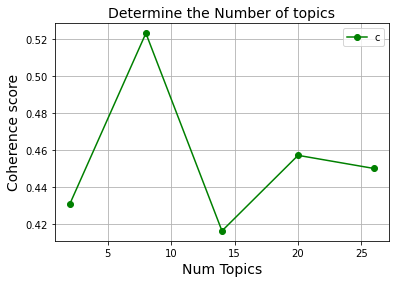

In [27]:
dictionary=id2word
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=2, limit=30, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=30; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values, color='green', marker='o')
plt.title("Determine the Number of topics", fontsize='14')
plt.xlabel("Num Topics", fontsize='14')
plt.ylabel("Coherence score", fontsize='14')
plt.legend(("coherence_values"), loc='best')
plt.grid(True)
plt.show()

### Hyperparameter tunning
This will generate a result and save a file that will justify our topic number (K)

In [28]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

### Perform a grid search 
Because of the number of iterations on alpha, eta, k, and coherence, this will take about 7 hours to complete, depending on your processor speed.

In [29]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [#gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.25)), 
               #gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.5)), 
                gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('LDAdbpedia_result.csv', index=False)
    pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [8:20:07<00:00, 55.57s/it]


### Evaluate the CSV file results and use the appropriate parameters.

In [30]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.91)

In [42]:
#Compute Perplexity score
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
# Compute Coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\danla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -8.68242854586701

Coherence Score:  0.5655054581264419


In [35]:
from pyLDAvis import gensim

C:\Users\danla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Visualize the topics

In [64]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.enable_notebook(LDAvis_prepared)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.208323 -0.094641       1        1  52.078015
3     -0.181413  0.106991       2        1  28.298848
4     -0.002889  0.016059       3        1   8.917262
0      0.049399 -0.059656       4        1   5.523106
6      0.081719  0.005915       5        1   2.045887
5      0.087851  0.004515       6        1   1.566151
7      0.087099  0.009652       7        1   0.947392
1      0.086556  0.011164       8        1   0.623339, topic_info=                       Term         Freq        Total Category  logprob  \
405                    team  1958.000000  1958.000000  Default  30.0000   
12                     play  2234.000000  2234.000000  Default  29.0000   
871                  season  1619.000000  1619.000000  Default  28.0000   
83                      win  1771.000000  1771.000000  Default  27.0000   
267                  league  1495.000000  1495.000000  Default  26.0000   
...                     ...          ...          ...      ...      ...   
22382              seminary     1.198851    25.159340   Topic8  -8.0497   
21458  federal_correctional     0.734205     7.851343   Topic8  -8.5401   
22493           male_inmate     0.764766    12.118527   Topic8  -8.4993   
4942                    jan     0.715674    42.467097   Topic8  -8.5656   
981                 diocese     0.731171   163.793618   Topic8  -8.5442   

       loglift  
405    30.0000  
12     29.0000  
871    28.0000  
83     27.0000  
267    26.0000  
...        ...  
22382   2.0340  
21458   2.7082  
22493   2.3149  
4942    0.9946  
981    -0.3339  

[469 rows x 6 columns], token_table=       Topic      Freq                     Term
term                                           
46844      1  0.202692                    abbas
46844      2  0.202692                    abbas
46844      6  0.405384                    abbas
2411       1  0.068249  administrative_district
2411       2  0.068249  administrative_district
...      ...       ...                      ...
57001      2  0.233767                    zakka
57001      8  0.233767                    zakka
798        1  0.192105                     محمد
798        2  0.192105                     محمد
798        6  0.384210                     محمد

[1383 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 7, 6, 8, 2])